In [17]:

import pandas as pd
import numpy as np

import sys
print(sys.version)

from sklearn.feature_extraction.text import CountVectorizer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re


import pickle 
#import mglearn
import time


from nltk.tokenize import TweetTokenizer # doesn't split at apostrophes
from nltk import Text
from nltk.tokenize import regexp_tokenize
from nltk.tokenize import word_tokenize 
import nltk


from nltk.tokenize import sent_tokenize 
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

from clean_data import clean_description as clean_des


3.6.5 |Anaconda, Inc.| (default, Apr 29 2018, 16:14:56) 
[GCC 7.2.0]


In [18]:
## Data description

df = pd.read_csv('../data/book_data.csv')
df.drop(["src", "cover"], inplace=True, axis=1) #useless columns
total = df.isnull().sum().sort_values(ascending=False)
print("***DATA INFORMATION***")

print(df.groupby(['genre']).count()["id"])
#print(df["genre"].describe())
print("dimension of data {}".format(df.shape))
df.head()


***DATA INFORMATION***
genre
1                       1
1999                    1
2005                    1
Science-fiction         1
Self-help               1
adventure             684
art                   599
biography            2612
biology                40
business             1151
chick-lit             721
children             3663
comics                369
computer-science       80
cookbook              514
drama                 515
economics             202
entrepreneurship       15
fantasy              6929
fiction              6857
finance               216
gr                     42
health                605
historical           1427
history              3178
horror               1302
humour                423
math                  199
mystery              4843
nil                 57204
non-fiction          4996
philosophy            553
physics                21
politics              743
psychology            769
religion             1179
romance              4092
science  

/home/sloth/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Unnamed: 0  id                                         book_title  \
0           0  89  Factfulness: Ten Reasons We're Wrong About the...   
1           1  90                       Magic, Madness, and Mischief   
2           2  91                         Spirits, Spells, and Snark   
3           3  92  First Kisses and Other Misfortunes (Grimbaud, ...   
4           4  93  Law School Confidential: A Complete Guide to t...   

                                             authors pub_year        genre  \
0  [Hans Rosling, Anna Rosling Rönnlund, Ola Rosl...     2018  non-fiction   
1                                 [Kelly McCullough]     2018      fantasy   
2                                 [Kelly McCullough]     2019      fantasy   
3                                [Kimberly Karalius]     2016  young-adult   
4                              [Robert H.    Miller]     2015  non-fiction   

                                         description  
0  Factfulness: The stress-reducing habit of only...  
1  "A 12-year-old boy uses his new magical powers...  
2  Kalvan Monroe is worried. Every story he's eve...  
3  In Kimberly Karalius's First Kisses and Other ...  
4  I WISH I KNEW THEN WHAT I KNOW NOW!\n\nDon't g...

In [19]:
print("Fixing dirty data")
# strange genres
df.genre[df.genre=="scifi3"] = "science-fiction"
df.genre[df.genre=="Science-fiction"] = "science-fiction"
df.genre[df.genre=="scifi"] = "science-fiction"
df.genre[df.genre=="Self-help"] = "self-help"

print("Removing rows of corrupted data from df")
df = df[df.genre != "1"]
df = df[df.genre != "1999"]
df = df[df.genre != "2005"]
print(df.groupby(['genre']).count()["id"])
GENRE_LIST = df["genre"].unique()
print("Genres available: ")
print(GENRE_LIST)


/home/sloth/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/sloth/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Fixing dirty data


/home/sloth/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/sloth/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Removing rows of corrupted data from df
genre
adventure             684
art                   599
biography            2612
biology                40
business             1151
chick-lit             721
children             3663
comics                369
computer-science       80
cookbook              514
drama                 515
economics             202
entrepreneurship       15
fantasy              6929
fiction              6857
finance               216
gr                     42
health                605
historical           1427
history              3178
horror               1302
humour                423
math                  199
mystery              4843
nil                 57204
non-fiction          4996
philosophy            553
physics                21
politics              743
psychology            769
religion             1179
romance              4092
science              1352
science-fiction      2031
self-help            1037
social-science         30
thriller          

In [20]:
print("remove books with \"nil\" description")

#27 titles with "nil" description

df['desc_word_count']=df["description"].apply(lambda x: len(str(x).split()))
print(df["book_title"].count())
print("Number of books with 0/1 word")
print(df[df.desc_word_count == 0].count())
print(df[df.desc_word_count == 1].count())

df=df[df.desc_word_count != 1]
df=df[df.desc_word_count != 0]

print(df.columns)
print("Number of books left after books with no descriptions")
print(df["book_title"].count())





remove books with "nil" description
117502
Unnamed: 0         5
id                 5
book_title         5
authors            5
pub_year           5
genre              5
description        5
desc_word_count    5
dtype: int64
     Unnamed: 0   id                                         book_title  \
33           33  122                                 All Roads End Here   
55           55  144  Zendoodle Coloring Presents Fairies in Dreamla...   
123         123  212                           Fowler: My Autobiography   
135         135  224                           Fowler: My Autobiography   
165         165  254                       Space, Black Holes And Stuff   
167         167  256    Brains, Bodies, Guts And Stuff (Science Museum)   
177         177  266  Danny Baker Record Breaker (2): The World's Aw...   
183         183  272                                    Antigona and Me   
258         258  347                                      Romantic Dogs   
267         267  356      

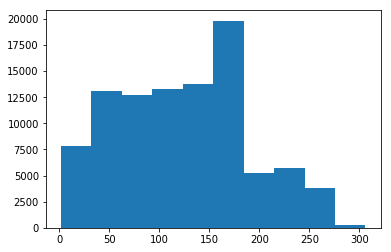

In [21]:

#plt.hist(df['desc_word_count'])
#plt.show()

In [22]:
print(df.groupby(['genre']).count()["id"])
df.shape

genre
adventure             631
art                   522
biography            2276
biology                33
business              996
chick-lit             666
children             3230
comics                337
computer-science       56
cookbook              415
drama                 473
economics             167
entrepreneurship        8
fantasy              6527
fiction              6067
finance               182
health                529
historical           1344
history              2824
horror               1207
humour                379
math                  157
mystery              4544
nil                 41598
non-fiction          4009
philosophy            470
physics                13
politics              653
psychology            663
religion             1005
romance              3670
science              1114
science-fiction      1845
self-help             915
social-science         22
thriller             1078
travel                609
young-adult          4269
Name: 

(95503, 8)

In [23]:
print("Separate test data?")
train_df = df[df.genre != "nil"]
test_df = df[df.genre == "nil"]

print(train_df.shape)
print(test_df.shape)

Separate test data?
(53905, 8)
(41598, 8)


In [24]:
print(train_df[train_df["genre"]==""])
train_df['description']=(train_df['description'].apply(clean_des))
test_df['description']=(test_df['description'].apply(clean_des))

Empty DataFrame
Columns: [Unnamed: 0, id, book_title, authors, pub_year, genre, description, desc_word_count]
Index: []


/home/sloth/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/sloth/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
print("start")
tf = TfidfVectorizer(smooth_idf=False, min_df=2, max_df=0.8,sublinear_tf=False, norm=None, analyzer='word')

df['description']=(df['description'].apply(clean_des))

#df['book_title']=(df['book_title'].apply(clean_description))

print(df.shape)
df = df[df.description!=""]
df = df[df.description!=np.nan]
print(df.shape)

txt_fitted=tf.fit(df['description'].values.astype('U'))

txt_transformed = txt_fitted.transform(df['description'].values.astype('U'))


idf = tf.idf_

#print(dict(zip(txt_fitted.get_feature_names(), idf)))


start
(95503, 8)
(95494, 8)


In [26]:
feature_names = np.array(tf.get_feature_names())
sorted_by_idf = np.argsort(tf.idf_)
print("Features with lowest idf:\n{}".format(
       feature_names[sorted_by_idf[:10]]))

Features with lowest idf:
['book' 'one' 'life' 'new' 'time' 'world' 'find' 'stori' 'make' 'year']


In [27]:
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=False)

def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [28]:
#instead of dumping tfidf into the logistic, dump count into tfidf

In [29]:
cv=CountVectorizer(max_df=0.85, analyzer="word")
cv.fit(train_df["description"])
xtrain_count_vector =  cv.transform(train_df["description"])
 

In [30]:
print(cv.get_feature_names())
print(train_df["description"].head())

['aa', 'aaa', 'aaaaaand', 'aaaall', 'aachan', 'aachen', 'aachim', 'aaden', 'aadet', 'aaesop', 'aahz', 'aakash', 'aama', 'aan', 'aandr', 'aang', 'aann', 'aantal', 'aantrekkingskracht', 'aard', 'aardkinderen', 'aardvark', 'aaron', 'aaronbest', 'aaronsohn', 'aarp', 'aarya', 'aasect', 'aasif', 'aastal', 'aatish', 'ab', 'ababa', 'abacha', 'aback', 'abaddon', 'abadesa', 'abagail', 'abaguchi', 'abak', 'abalamahalamatandra', 'abalon', 'abanbon', 'aband', 'abandon', 'abandonada', 'abandonado', 'abandonan', 'abandonar', 'abandond', 'abandonn', 'abandonne', 'abandonné', 'abandono', 'abani', 'abanon', 'abaord', 'abarca', 'abarrach', 'abascar', 'abat', 'abata', 'abatido', 'abatt', 'abattoir', 'abawi', 'abba', 'abbadon', 'abbandona', 'abbandonata', 'abbasid', 'abberdorf', 'abberlin', 'abberufen', 'abbess', 'abbey', 'abbi', 'abbia', 'abbigal', 'abbondanza', 'abbot', 'abbotsvill', 'abbott', 'abbottabad', 'abbottsford', 'abbrevi', 'abbé', 'abc', 'abcd', 'abd', 'abdallah', 'abdel', 'abdi', 'abdic', 'abd

In [31]:
 from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(xtrain_count_vector)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [32]:
doc=train_df["description"].tolist()[0]
print(doc)

feature_names=cv.get_feature_names()
tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))
 
tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))
print("sht")
sorted_items=sort_coo(tf_idf_vector.tocoo())

fact habit carri opinion strong support fact ask simpl question global percentag world popul live poverti world popul increas mani girl finish systemat get answer wrong wrong chimpanze choos answer random consist outguess teacher journalist nobel laureat invest banker fact professor intern health global ted phenomenon han rosl togeth two collabor anna ola offer radic new explan happen reveal ten instinct distort tendenc divid world two camp usual version us way consum media fear rule perceiv progress believ thing get wors problem know
sht


In [33]:
#extract only the top n; n here is 10
keywords=extract_topn_from_vector(feature_names,sorted_items,10)
 
# now print the results
print("\n=====Doc=====")
print(doc)
print("\n===Keywords===")
for k in keywords:
    print(k,keywords[k])
 
 


=====Doc=====
fact habit carri opinion strong support fact ask simpl question global percentag world popul live poverti world popul increas mani girl finish systemat get answer wrong wrong chimpanze choos answer random consist outguess teacher journalist nobel laureat invest banker fact professor intern health global ted phenomenon han rosl togeth two collabor anna ola offer radic new explan happen reveal ten instinct distort tendenc divid world two camp usual version us way consum media fear rule perceiv progress believ thing get wors problem know

===Keywords===
new 0.04
live 0.049
way 0.053
know 0.056
thing 0.062
mani 0.063
girl 0.063
us 0.067
togeth 0.067
offer 0.067


In [34]:
X_train, X_test, y_train, y_test = train_test_split(train_df["description"], train_df["genre"], test_size= 0.1, random_state=13)

In [35]:
# Instantiate the vectorizer
word_vectorizer = TfidfVectorizer(min_df=2, max_df=0.8,
    stop_words='english',
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{2,}',  #vectorize 2-character words or more
    ngram_range=(1, 1),
    max_features=300000)
# fit and transform on it the training features
print("OK!")
word_vectorizer.fit(X_train)
X_train_word_features = word_vectorizer.transform(X_train)

#transform the test features to sparse matrix
test_features = word_vectorizer.transform(X_test)


OK!


In [36]:
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 2, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

logistic = LogisticRegression()
classifier = GridSearchCV(logistic, hyperparameters, cv=5, verbose=0)
print("done w gridsearch2")

done w gridsearch2


In [37]:
print("begin3")
best_model=classifier.fit(X_train_word_features, y_train)
print("begin3")
y_pred = classifier.predict(test_features)
y_pred_prob = classifier.predict_proba(test_features)[:, 1]
print("test!!!!!!!!!!!!!!!!")
cv_score = np.mean(cross_val_score(classifier, X_train_word_features, y_train,
                                   cv=5,scoring='accuracy'))
print('CV Accuracy score is {}'.format( cv_score))
print("gridsearchCV done")
# View best hyperparameters
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

begin3
begin3
test!!!!!!!!!!!!!!!!
CV Accuracy score is 0.6107322646758823
gridsearchCV done
Best Penalty: l2
Best C: 21.544346900318832


In [38]:
print(y_test.shape)
print(y_pred.shape)
test_features = word_vectorizer.transform(X_test)
y_pred_prob = classifier.predict_proba(test_features).argmax(axis=-1)
print(type(y_pred_prob))
print(y_pred_prob.shape)


for i in range(40,100):
    print(i)
    print(y_test.iloc[i],y_pred[i] )
    print(y_pred_prob[i])
    print("***********")



(5391,)
(5391,)
<class 'numpy.ndarray'>
(5391,)
40
thriller mystery
22
***********
41
biography non-fiction
23
***********
42
self-help self-help
32
***********
43
fiction fiction
14
***********
44
self-help religion
28
***********
45
non-fiction non-fiction
23
***********
46
romance romance
29
***********
47
biography fiction
14
***********
48
humour non-fiction
23
***********
49
mystery mystery
22
***********
50
mystery fiction
14
***********
51
fantasy fantasy
13
***********
52
business non-fiction
23
***********
53
fantasy fantasy
13
***********
54
young-adult young-adult
36
***********
55
history history
18
***********
56
fiction fiction
14
***********
57
business history
18
***********
58
fantasy fantasy
13
***********
59
thriller thriller
34
***********
60
biography biography
2
***********
61
psychology psychology
27
***********
62
children children
6
***********
63
science-fiction science-fiction
31
***********
64
history history
18
***********
65
thriller mystery
22
**********

In [39]:
def get_best_score(grid):
    
    best_score = np.sqrt(-grid.best_score_)
    print(best_score)    
    print(grid.best_params_)
    print(grid.best_estimator_)
    
    return best_score

In [40]:
#print("best")
#print('Best pen:', best_model.best_estimator_.get_params())
#pd.options.display.max_colwidth = 1000

##print(len(X_test))
#print(type(y_test))
print(type(y_pred))

#for i in range(3,100):
#    print(X_test.iloc[i])
#    print("ground truth: {}".format(str(y_test.iloc[i])))
#    print("predict: {}".format(str(y_pred[i])))


<class 'numpy.ndarray'>


In [41]:
sample1=test_df[50:90]
book_idx=44
print(sample1.iloc[book_idx]["book_title"])
sample1.iloc[book_idx]["description"]


IndexError: single positional indexer is out-of-bounds

In [ ]:
def get_top_5_predictions(predictions):
    genre_list = train_df["genre"]
    print(genre_list.shape)
    return

get_top_5_predictions("bla")

In [ ]:
best_model
sample1_word_features = word_vectorizer.transform(sample1)

y_pred = classifier.predict(test_features)
y_pred = classifier.predict(test_features)
y_pred_prob = classifier.predict_proba(test_features)
print(y_pred[book_idx])

In [ ]:
y_classes = y_pred_prob.argmax(axis=-1)
y_classes
print(y_classes[book_idx]
     )


In [ ]:
classifier.__dict__

In [ ]:
print